In [11]:

import numpy as np
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import datetime

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

import tensorflow.compat.v1 as tf 
from tensorflow.python.eager import context
from tensorflow.compat.v1 import keras
from tensorflow.compat.v1.keras.callbacks import ReduceLROnPlateau
from tensorflow.compat.v1.keras import layers,metrics,losses,optimizers,backend
from tensorflow.compat.v1.keras.applications.resnet50 import ResNet50
from tensorflow.compat.v1.keras.applications.vgg16 import VGG16
tf.enable_eager_execution() 
eager = context.executing_eagerly()
print(eager)
print(tf.__version__)


True
1.15.5


In [12]:
datagen = keras.preprocessing.image.ImageDataGenerator(
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [13]:
batch_size = 32
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            resized_arr = cv2.resize(img_arr, (img_size, img_size))
            data.append([resized_arr,class_num])
    return np.array(data)

In [14]:
train = get_training_data('.\\chest_xray\\train')
test = get_training_data('.\\chest_xray\\test')
val = get_training_data('.\\chest_xray\\val')

Text(0.5, 1.0, 'NORMAL')

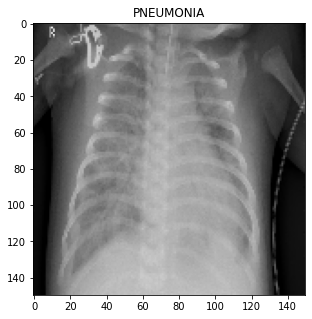

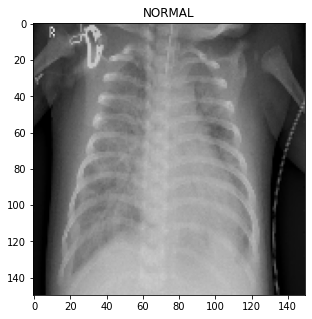

In [15]:

plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[val[-1][1]])

In [16]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [17]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [18]:
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [21]:
resnet = ResNet50(include_top=False,input_shape=(img_size,img_size,1),weights=None,pooling="avg")#,input_shape=(img_size,img_size,1)
resnet.summary()
model=keras.Sequential()
model.add(resnet)
model.add(layers.Dense(units=1000,activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="Adam",metrics=['accuracy'])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
model.load_weights('./weights/restnet100epoch/restnetweights')


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 1)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [11]:
log_dir = ".\\logs\\fit\\resnet100epochs\\"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
history = model.fit(datagen.flow(x_train,y_train,batch_size=32),epochs=100,validation_data=(x_val,y_val),callbacks=[learning_rate_reduction,tensorboard_callback])
model.save_weights('./weights/restnet100epoch/restnetweights')

Train on 5216 samples, validate on 16 samples
Epoch 1/100
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
5216/5216 [==============================] - 33s 6ms/sample - loss: 0.4668 - acc: 0.8447 - val_loss: 6.3921 - val_acc: 0.5000
Epoch 2/100
5216/5216 [==============================] - 26s 5ms/sample - loss: 0.2488 - acc: 0.9022 - val_loss: 4.5511 - val_acc: 0.5000
Epoch 3/100
5184/5216 [============================>.] - ETA: 0s - loss: 0.2106 - acc: 0.9142
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
5216/5216 [==============================] - 25s 5ms/sample - loss: 0.2116 - acc: 0.9139 - val_loss: 5.9955 - val_acc: 0.5000
Epoch 4/100
5216/5216 [==============================] - 25s 5ms/sample - loss: 0.1600 - acc: 0.9383 - val_loss: 3.7216 - val_acc: 0.5000
Epoch 5/100
5216/5216 [==============================] - 25s 5ms/sample - loss: 0.1475 - acc: 0.9490 - val_loss: 2.5303 - val_acc: 0.5625
Epoch 6/

resnet100epochs
accuracy: 0.9230769230769231 f1: 0.8909090909090909


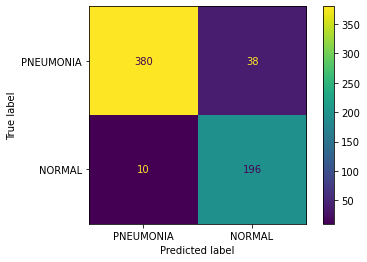

In [22]:
print("resnet100epochs")
y_pred = model.predict_classes(x_test)
acc = accuracy_score(y_pred,y_test)
f1 = f1_score(y_pred,y_test)
conf = confusion_matrix(y_pred,y_test)
print("accuracy:",acc,"f1:",f1)
yep = ConfusionMatrixDisplay(conf,display_labels=['PNEUMONIA', 'NORMAL'])
yep.plot()
plt.show()